Importing all required libraries

In [17]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

Episode No. 1 : 3.20000000000001
Episode No. 2 : 2.400000000000004
Episode No. 3 : 7.699999999999999
Episode No. 4 : 6.600000000000003
Episode No. 5 : 5.300000000000006
Episode No. 6 : 9.7
Episode No. 7 : 13.7
Episode No. 8 : 2.1000000000000103
Episode No. 9 : 7.799999999999999
Episode No. 10 : 14.4
Episode No. 11 : 7.199999999999999
Episode No. 12 : 13.7
Episode No. 13 : 11
Episode No. 14 : 4.600000000000007
Episode No. 15 : 5.999999999999999
Episode No. 16 : 12.2
Episode No. 17 : 10.1
Episode No. 18 : 11
Episode No. 19 : 7.6
Episode No. 20 : 9.1
Episode No. 21 : 6.699999999999998
Episode No. 22 : 10.9
Episode No. 23 : 12.8
Episode No. 24 : 12.8
Episode No. 25 : 12.8
Episode No. 26 : 3.0000000000000036
Episode No. 27 : 14.6
Episode No. 28 : 11.5
Episode No. 29 : 11.9
Episode No. 30 : 9.1
Episode No. 31 : 11.299999999999999
Episode No. 32 : 14.6
Episode No. 33 : 12.8
Episode No. 34 : 10.8
Episode No. 35 : 11
Episode No. 36 : 12.8
Episode No. 37 : 12.8
Episode No. 38 : 14.2
Episode No. 

/Users/abhinavchhabra/penv/lib/python3.11/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment GridWorld-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


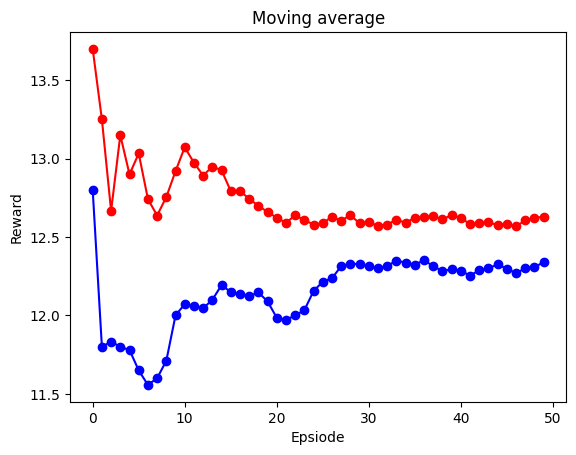

In [18]:
epsilon = 0.1
learning_rate = 0.1
discount_factor = 1
SIZE = 4

class Q_agent():
    def __init__(self,n_targets,n_states,n_actions):
        self.Q = np.zeros((n_targets,n_states,n_actions))
    def q_update(self,m,s,a,r,s_next,alpha,y):
        self.Q[m,s][a] += alpha*(r+y*max(self.Q[m,s_next])-self.Q[m,s][a])

class GridWorldEnv(gym.Env):
    def __init__(self,size = SIZE,max_steps = 100):
        self.size = size
        self.action_space = spaces.Discrete(4)
        self.max_steps = max_steps
        self.current_step = 0
        self.valid_choices = [(i,j) for i in range(self.size) for j in range(self.size)]
        self.actiontodir = {
            0 : np.array([1,0]), #move right
            1 : np.array([0,1]), #move up
            2 : np.array([-1,0]), #move left
            3 : np.array([0,-1]), #move down
        }
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=np.array([self.size-1, self.size-1]), dtype=int),
            "target": spaces.Box(low=0, high=np.array([self.size-1, self.size-1]), dtype=int)
        })
    def reset(self,seed = None, options = None):
        super().reset(seed=seed)
        self.positions = np.random.choice(len(self.valid_choices),2,replace = False)
        self.agentlocation = np.array(self.valid_choices[self.positions[0]])
        self.targetlocation = np.array(self.valid_choices[self.positions[1]])
        observation = self.getobs()
        info = {}
        self.current_step = 0
        return observation,info

    def getobs(self):
        return{"agent" : self.agentlocation, "target" : self.targetlocation}
    def step(self,action):
        move = self.actiontodir[action]
        x = self.agentlocation
        self.current_step += 1
        truncated = self.current_step>=self.max_steps
        self.agentlocation = np.clip(self.agentlocation + move,0,self.size-1) #np.clip ensures u move only within the grid which varies from 0 to size-1
        terminated = np.array_equal(self.agentlocation,self.targetlocation)
        check = np.linalg.norm(self.agentlocation-self.targetlocation)<np.linalg.norm(x-self.targetlocation)
        observation = self.getobs()
        reward = 1 if check else -1
        inc = 10 if terminated else -0.1 #So basically for moving closer u get a reward 1 but for reaching you get 10
        dec = 10 if truncated else 0
        reward += inc
        reward -= dec
        return observation,reward,terminated,truncated,{}
    gym.register(
        id='GridWorld-v0',
        entry_point= __name__ + ':GridWorldEnv'
    )   
def test(epsilon,a):
    env = gym.make('GridWorld-v0')
    episodes = 500
    observation,info = env.reset()
    agent = Q_agent(SIZE*SIZE,n_states = SIZE*SIZE,n_actions = 4)
    average = []
    ep = np.arange(0,50)
    total_reward = 0
    for i in range(episodes):
        terminated = False
        truncated = False
        total = 0
        sum = 0
        m = tuple(observation["target"])[0]*4 + tuple(observation["target"])[1]
        while(not terminated and not truncated):
            s = tuple(observation["agent"])[0]*4 + tuple(observation["agent"])[1]
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else : 
                action = np.argmax(agent.Q[m,s])
            observation,reward,terminated,truncated,info = env.step(action)
            st = tuple(observation["agent"])[0]*4 + tuple(observation["agent"])[1]
            total += reward
            sum += reward
            Q = agent.q_update(m,s,action,reward,st,learning_rate,discount_factor)
        observation,info = env.reset()
        print("Episode No.", i+1 ,":", total)
        if(i>=episodes-50):
            total_reward += sum
            average.append(total_reward/(i-episodes+51))
    plt.plot(ep,average,marker = 'o', c = a, label = f'e = {epsilon}')
    env.close()
test(0.1,a = 'r')
test(0.2 , a = 'b')
plt.title('Moving average')
plt.xlabel('Epsiode')
plt.ylabel('Reward')
plt.show()
    



The Rewards for epsilon = 0.1 are better as we depend more on the predictions based on the Q table rather than taken random actions. The probability of taking random actions is higher for epsilon = 0.2